In [1]:
import datetime
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from dateutil.parser import parse
#from google.colab import drive

ProgressBar().register()

In [149]:
PU_mobility_counts = pd.read_csv('data/PU_Mobility_counts.csv',  index_col='Unnamed: 0')
DO_mobility_counts = pd.read_csv('data/DO_Mobility_counts.csv',  index_col='Unnamed: 0')

In [150]:
PU_cluster_dict = {}

for clust in range(0,5):
    PU_cluster_dict[clust] = PU_mobility_counts[PU_mobility_counts['PU_cluster'] == clust]['PULocationID'].unique()

In [151]:
DO_cluster_dict = {}

for clust in range(0,5):
    DO_cluster_dict[clust] = DO_mobility_counts[DO_mobility_counts['DO_cluster'] == clust]['DOLocationID'].unique()

In [152]:
acs = pd.read_csv('data/ACS_taxizone_cluster.csv')

In [153]:
taxi = gpd.read_file('data/taxi_zones__7_/taxi_zones.shp')
taxi = taxi[['zone','LocationID','geometry']]

In [154]:
zone_counts = taxi.merge(acs[['LocationID','essential_workers']], on='LocationID', how='right')

In [254]:
## Import Test set ride data with Probability and Model Label info

FinalPred = dd.read_csv('data/FinalTestPredictions2.csv', assume_missing=True)
FinalPred = FinalPred.dropna()

In [255]:
FinalPred['PULocationID'] = FinalPred['PULocationID'].astype(int)
FinalPred['DOLocationID'] = FinalPred['DOLocationID'].astype(int)

In [256]:
len(FinalPred) # Number of Oberservations for Test Set

[########################################] | 100% Completed | 16.8s


3627524

In [257]:
## Import test set ride data with True overnight labels

test_set = dd.read_csv('data/FHV_test_set.csv', assume_missing=True)
test_set = test_set.dropna()

In [314]:
test_set['PULocationID'] = test_set['PULocationID'].astype(int)
test_set['DOLocationID'] = test_set['DOLocationID'].astype(int)

In [260]:
len(test_set)

[########################################] | 100% Completed | 18.0s


3627524

In [261]:
## Create dataframe for PREDICTED overnight rides

pred_overnight = FinalPred[FinalPred['Label'] == 1].compute()

[########################################] | 100% Completed | 19.6s


In [262]:
len(pred_overnight) # Number of Predicted overnight rides (Much higher than true amount)

1040257

In [315]:
## Create dataframe for TRUE overnight rides

true_overnight = test_set[test_set['overnight'] == 1].compute()

[########################################] | 100% Completed | 25.2s


In [264]:
len(true_overnight) # Number of true (observed) overnightrides

284734

(array([0, 1]), [Text(0, 0, 'Predicted'), Text(1, 0, 'True')])

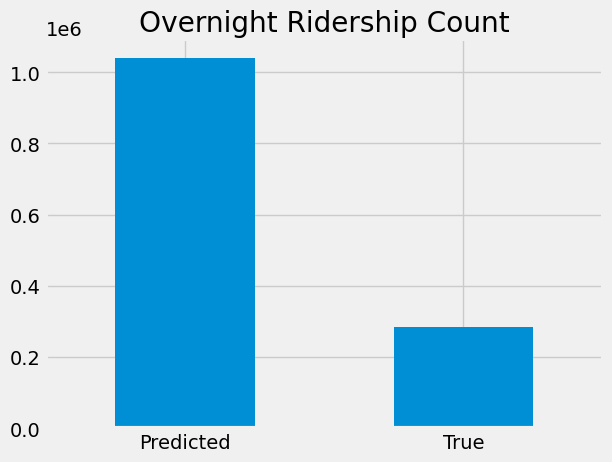

In [451]:
pd.DataFrame([len(pred_overnight), len(true_overnight)], index= ['Predicted','True']).plot.bar(legend=False)
plt.title('Overnight Ridership Count')
plt.xticks(rotation=0)

In [312]:
## Most Common PREDICTED Overnight Trips

pred_overnight[['PULocationID','DOLocationID']].value_counts()[:10]

PULocationID  DOLocationID
35            76              2579
76            76              2561
61            61              2341
39            76              2261
76            35              2240
42            42              1981
76            39              1914
37            37              1901
39            39              1839
225           61              1787
dtype: int64

In [316]:
## Most Common TRUE Overnight Trips


true_overnight[['PULocationID','DOLocationID']].value_counts()[:10]

PULocationID  DOLocationID
76            76              781
61            61              617
35            76              533
39            76              453
76            35              449
39            39              431
37            37              423
225           61              411
61            76              410
              35              388
dtype: int64

## Pickup Counts

In [424]:
predrides_count = pd.DataFrame(pred_overnight['PULocationID'].value_counts()).sort_index()\
.join(pd.DataFrame(pred_overnight['DOLocationID'].value_counts()).sort_index())
predrides_count = predrides_count.reset_index().dropna()

#predrides_count.columns = [['LocationID','Pickups','Dropoffs']]

In [425]:
predrides_count['PredRidesTotal'] = predrides_count['PULocationID'] + predrides_count['DOLocationID']
predrides_count['PU/DO Ratio'] = predrides_count['PULocationID'] / predrides_count['DOLocationID']

In [431]:
taxi[['LocationID','zone']].merge(predrides_count, left_on='LocationID', right_on='index').sort_values('PULocationID', ascending=False)[:10]

,LocationID,zone,index,PULocationID,DOLocationID,PredRidesTotal,PU/DO Ratio
58,61,Crown Heights North,61,29451,28810,58261,1.022249
39,42,Central Harlem North,42,24141,21317,45458,1.132476
34,37,Bushwick South,37,23699,21157,44856,1.120149
73,76,East New York,76,23421,27087,50508,0.864658
216,225,Stuyvesant Heights,225,17320,17397,34717,0.995574
32,35,Brownsville,35,17290,16741,34031,1.032794
36,39,Canarsie,39,16709,15774,32483,1.059275
160,168,Mott Haven/Port Morris,168,16219,18229,34448,0.889736
235,244,Washington Heights South,244,15421,17583,33004,0.877040
71,74,East Harlem North,74,14665,14337,29002,1.022878


## Dropoff Counts

In [432]:
truerides_count = pd.DataFrame(true_overnight['PULocationID'].value_counts()).sort_index()\
.join(pd.DataFrame(true_overnight['DOLocationID'].value_counts()).sort_index())
truerides_count = truerides_count.reset_index().dropna()


In [433]:
truerides_count['TrueRidesTotal'] = truerides_count['PULocationID'] + truerides_count['DOLocationID']
truerides_count['TrueRidesTotal'] = truerides_count['TrueRidesTotal'].astype(int)
truerides_count['PU/DO Ratio'] = truerides_count['PULocationID'] / truerides_count['DOLocationID']


In [434]:
taxi[['LocationID','zone']].merge(predrides_count, left_on='LocationID', right_on='index').sort_values('DOLocationID', ascending=False)[:10]

,LocationID,zone,index,PULocationID,DOLocationID,PredRidesTotal,PU/DO Ratio
58,61,Crown Heights North,61,29451,28810,58261,1.022249
73,76,East New York,76,23421,27087,50508,0.864658
39,42,Central Harlem North,42,24141,21317,45458,1.132476
34,37,Bushwick South,37,23699,21157,44856,1.120149
160,168,Mott Haven/Port Morris,168,16219,18229,34448,0.889736
235,244,Washington Heights South,244,15421,17583,33004,0.877040
216,225,Stuyvesant Heights,225,17320,17397,34717,0.995574
32,35,Brownsville,35,17290,16741,34031,1.032794
36,39,Canarsie,39,16709,15774,32483,1.059275
66,69,East Concourse/Concourse Village,69,14499,14910,29409,0.972435


## Total Overnight Ride Counts

In [271]:
rides_count = predrides_count[['index','PredRidesTotal']].merge(truerides_count[['index','TrueRidesTotal']], on='index')
rides_count.columns = ['LocationID','PredRidesTotal','TrueRidesTotal']
rides_count['PredRidesPct'] = rides_count['PredRidesTotal'] / rides_count['PredRidesTotal'].sum()
rides_count['TrueRidesPct'] = rides_count['TrueRidesTotal'] / rides_count['TrueRidesTotal'].sum()

rides_count['Pct_Residual'] = rides_count['TrueRidesPct'] - rides_count['PredRidesPct']


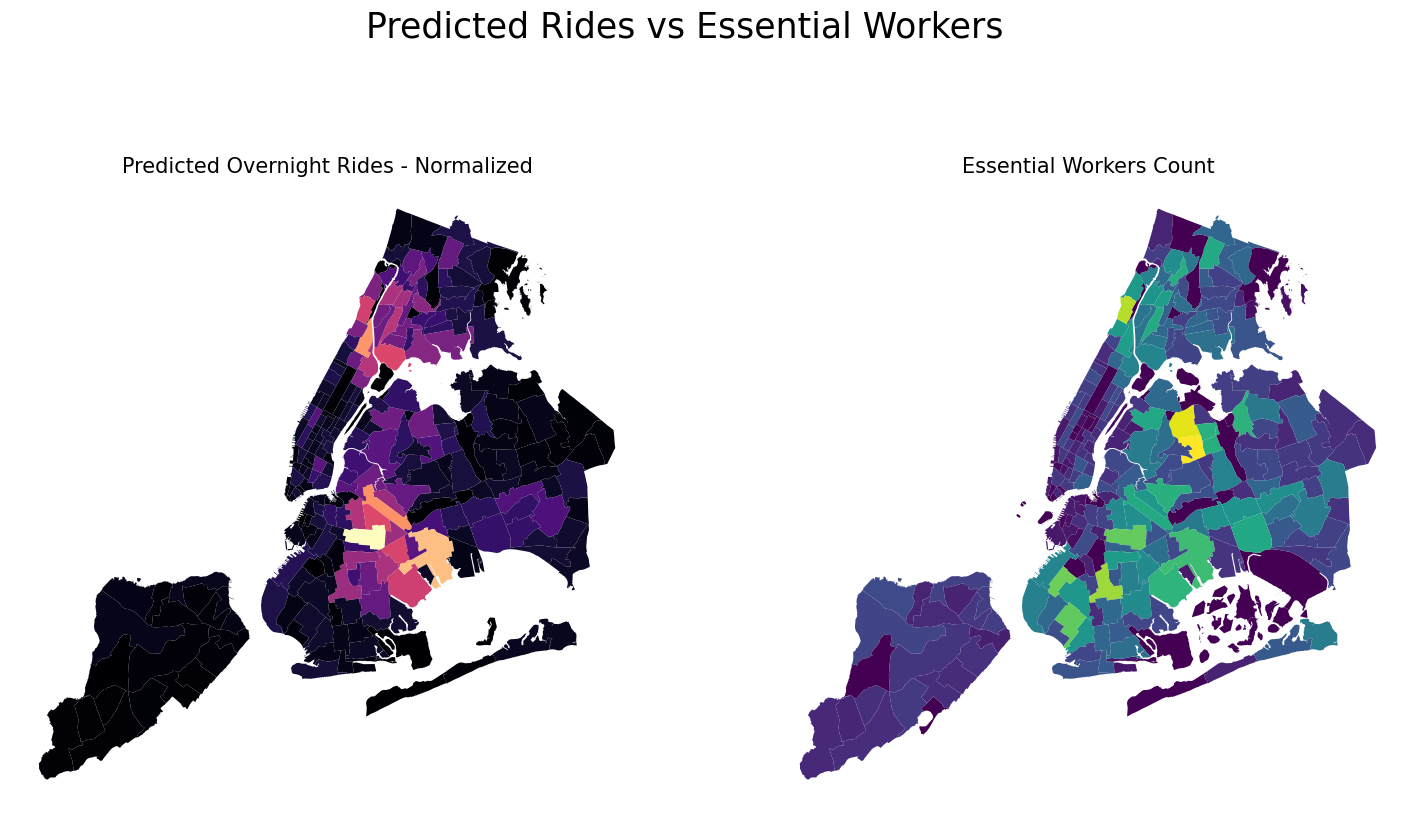

In [455]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1,2,figsize=(18,10))
plt.suptitle('Predicted Rides vs Essential Workers', fontsize=25)
taxi.merge(rides_count, on='LocationID', how='right').plot('PredRidesPct', ax=ax[0], cmap='magma')
ax[0].set_title('Predicted Overnight Rides - Normalized', fontsize=15)
ax[0].axis('off')
zone_counts.plot('essential_workers', ax=ax[1])
ax[1].set_title('Essential Workers Count', fontsize=15)
ax[1].axis('off')

#fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70)

plt.show()

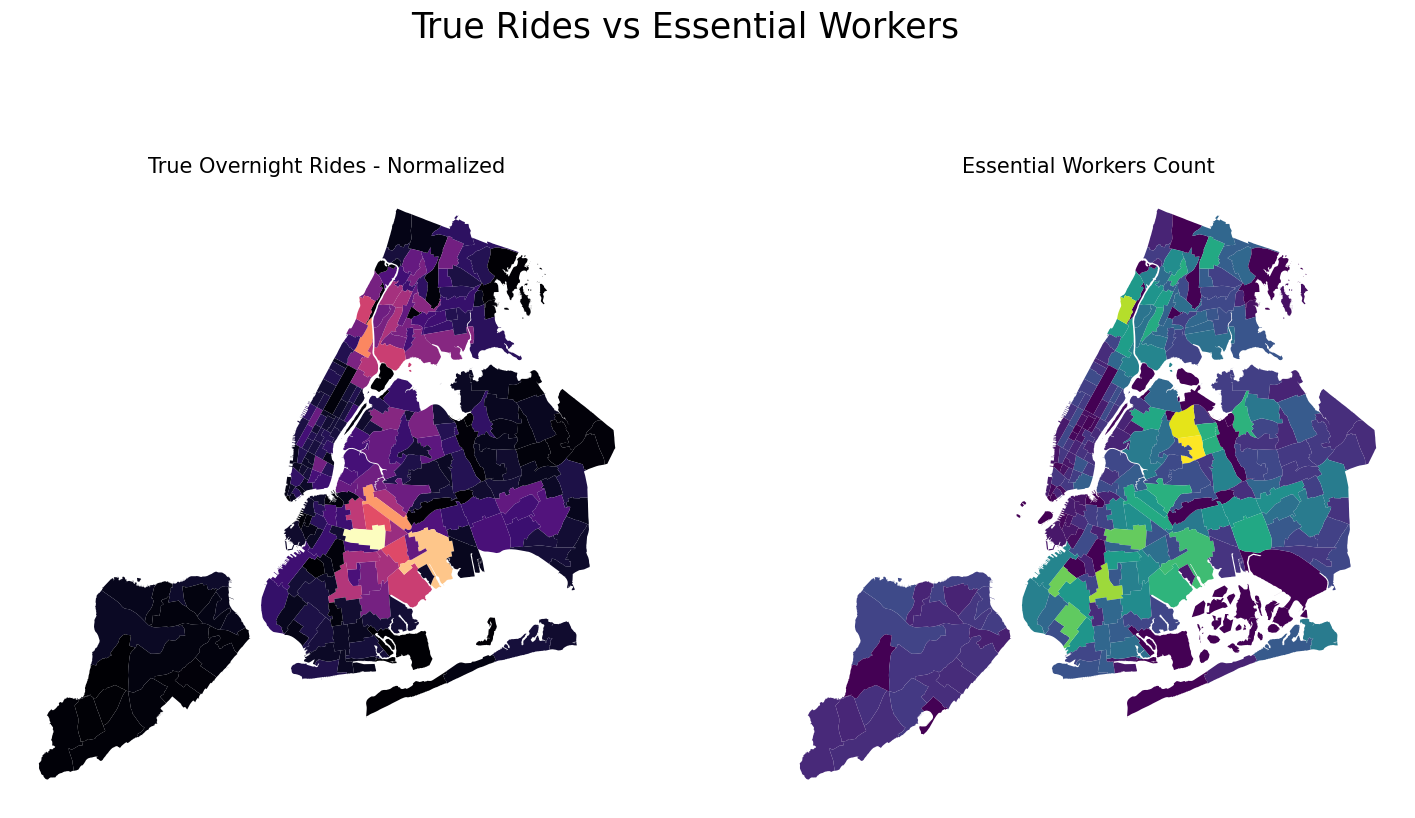

In [273]:
fig, ax = plt.subplots(1,2,figsize=(18,10))
plt.suptitle('True Rides vs Essential Workers', fontsize=25)
taxi.merge(rides_count, on='LocationID', how='right').plot('TrueRidesPct', ax=ax[0], cmap='magma')
ax[0].set_title('True Overnight Rides - Normalized', fontsize=15)
ax[0].axis('off')
zone_counts.plot('essential_workers', ax=ax[1])
ax[1].set_title('Essential Workers Count', fontsize=15)
ax[1].axis('off')

#fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70)

plt.show()

(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

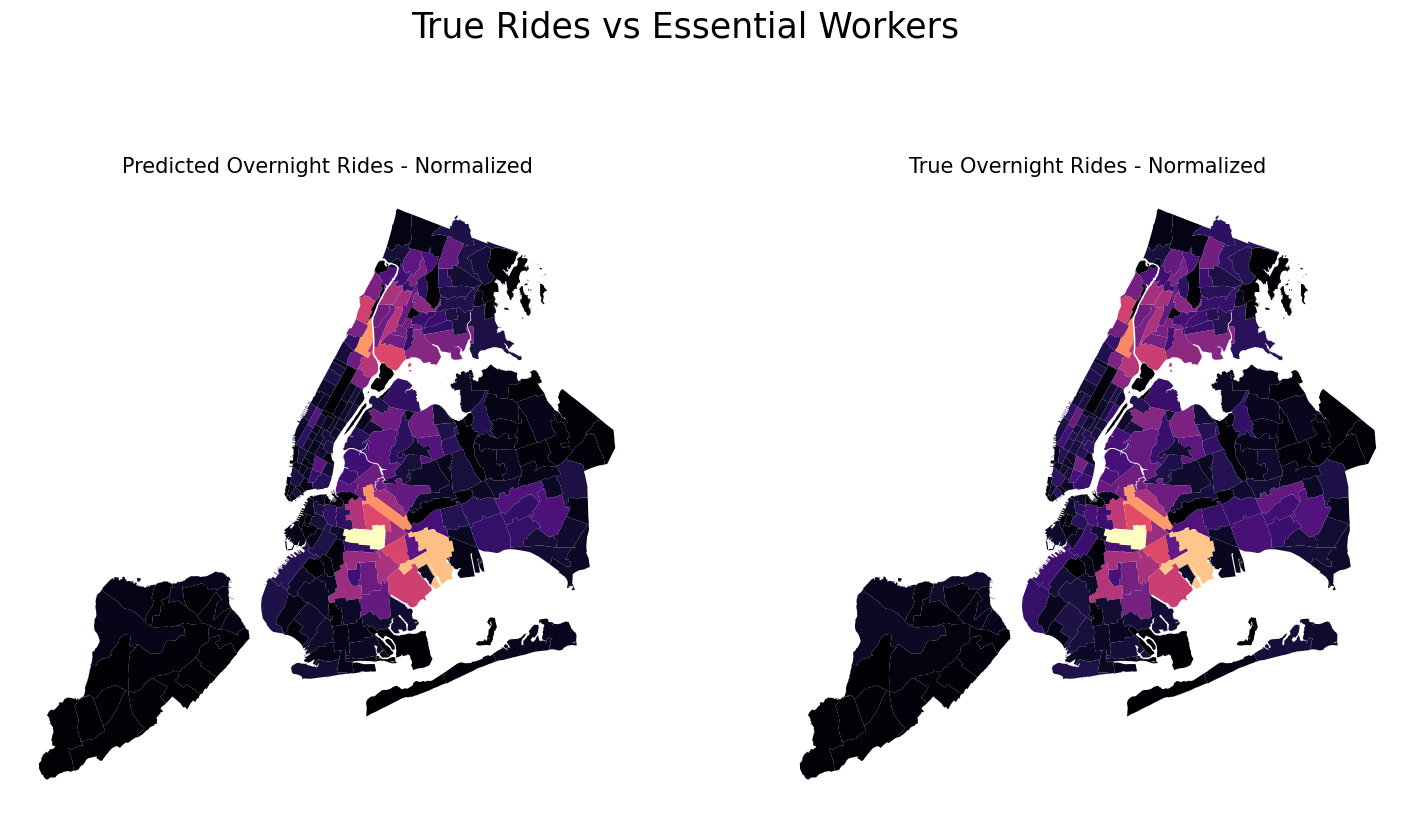

In [274]:
fig, ax = plt.subplots(1,2,figsize=(18,10))
plt.suptitle('True Rides vs Essential Workers', fontsize=25)
taxi.merge(rides_count, on='LocationID', how='right').plot('PredRidesPct', ax=ax[0], cmap='magma')
ax[0].set_title('Predicted Overnight Rides - Normalized', fontsize=15)
ax[0].axis('off')
taxi.merge(rides_count, on='LocationID', how='right').plot('TrueRidesPct', ax=ax[1], cmap='magma')
ax[1].set_title('True Overnight Rides - Normalized', fontsize=15)
ax[1].axis('off')

In [275]:
rides_count = predrides_count[['index','PredRidesTotal']].merge(truerides_count[['index','TrueRidesTotal']], on='index')
rides_count.columns = ['LocationID','PredRidesTotal','TrueRidesTotal']
rides_count['PredRidesPct'] = rides_count['PredRidesTotal'] / rides_count['PredRidesTotal'].sum()
rides_count['TrueRidesPct'] = rides_count['TrueRidesTotal'] / rides_count['TrueRidesTotal'].sum()

rides_count['Pct_Residual'] = rides_count['TrueRidesPct'] - rides_count['PredRidesPct']


In [276]:
rides_count.reindex(rides_count.Pct_Residual.abs().sort_values().index)

,LocationID,PredRidesTotal,TrueRidesTotal,PredRidesPct,TrueRidesPct,Pct_Residual
16,19,990,272,0.000476,0.000478,0.000002
79,83,4634,1271,0.002227,0.002232,0.000005
150,160,4574,1249,0.002199,0.002193,-0.000005
179,189,4646,1275,0.002233,0.002239,0.000006
103,111,87,20,0.000042,0.000035,-0.000007
...,...,...,...,...,...,...
65,69,29409,6608,0.014135,0.011604,-0.002532
72,76,50508,12186,0.024277,0.021399,-0.002878
158,168,34448,7587,0.016557,0.013323,-0.003234
39,42,45458,10356,0.021849,0.018185,-0.003664


(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

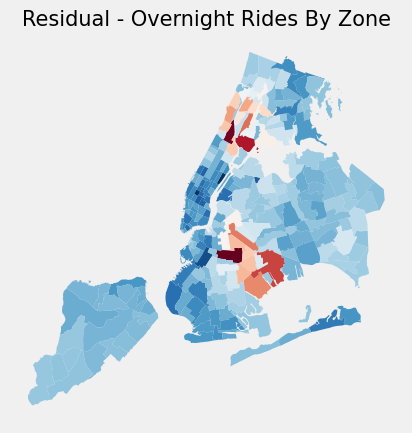

In [460]:


fig, ax = plt.subplots()

taxi[['LocationID','geometry']].merge(rides_count, on='LocationID').plot('Pct_Residual', cmap='RdBu', ax=ax, figsize=(12,10))
plt.title('Residual - Overnight Rides By Zone', fontsize=15)
ax.axis('off')
## Model Overlabels rides from the zones in darkest red

In [340]:
pred10 = taxi[['LocationID','zone']].merge(rides_count, on='LocationID').sort_values('PredRidesTotal', ascending=False)[:10]
pred10.style.set_caption('Top 10 Zones by Predicted Overnight Ride Count')

## Top 10 Zones by Predicted Overnight Ride Count

,LocationID,zone,PredRidesTotal,TrueRidesTotal,PredRidesPct,TrueRidesPct,Pct_Residual
58,61,Crown Heights North,58261,13810,0.028003,0.024251,-0.003752
73,76,East New York,50508,12186,0.024277,0.021399,-0.002878
39,42,Central Harlem North,45458,10356,0.021849,0.018185,-0.003664
34,37,Bushwick South,44856,10881,0.021560,0.019107,-0.002453
215,225,Stuyvesant Heights,34717,8428,0.016687,0.014800,-0.001887
159,168,Mott Haven/Port Morris,34448,7587,0.016557,0.013323,-0.003234
32,35,Brownsville,34031,8275,0.016357,0.014531,-0.001826
234,244,Washington Heights South,33004,7801,0.015863,0.013699,-0.002165
36,39,Canarsie,32483,7561,0.015613,0.013277,-0.002336
66,69,East Concourse/Concourse Village,29409,6608,0.014135,0.011604,-0.002532


In [341]:
true10 = taxi[['LocationID','zone']].merge(rides_count, on='LocationID').sort_values('TrueRidesTotal', ascending=False)[:10]
true10.style.set_caption('Top 10 Zones by True Overnight Ride Count')

## Top 10 Zones by True Overnight Ride Count

,LocationID,zone,PredRidesTotal,TrueRidesTotal,PredRidesPct,TrueRidesPct,Pct_Residual
58,61,Crown Heights North,58261,13810,0.028003,0.024251,-0.003752
73,76,East New York,50508,12186,0.024277,0.021399,-0.002878
34,37,Bushwick South,44856,10881,0.021560,0.019107,-0.002453
39,42,Central Harlem North,45458,10356,0.021849,0.018185,-0.003664
215,225,Stuyvesant Heights,34717,8428,0.016687,0.014800,-0.001887
32,35,Brownsville,34031,8275,0.016357,0.014531,-0.001826
234,244,Washington Heights South,33004,7801,0.015863,0.013699,-0.002165
159,168,Mott Haven/Port Morris,34448,7587,0.016557,0.013323,-0.003234
36,39,Canarsie,32483,7561,0.015613,0.013277,-0.002336
14,17,Bedford,28645,7203,0.013768,0.012649,-0.001120


In [321]:
taxi[taxi['LocationID'] == 256]

,zone,LocationID,geometry
255,Williamsburg (South Side),256,"POLYGON ((995798.638 199155.970, 996223.601 19..."


Text(0.5, 1.0, 'Overnight Rides by Essential Worker Count (Per Taxi Zone)\n')

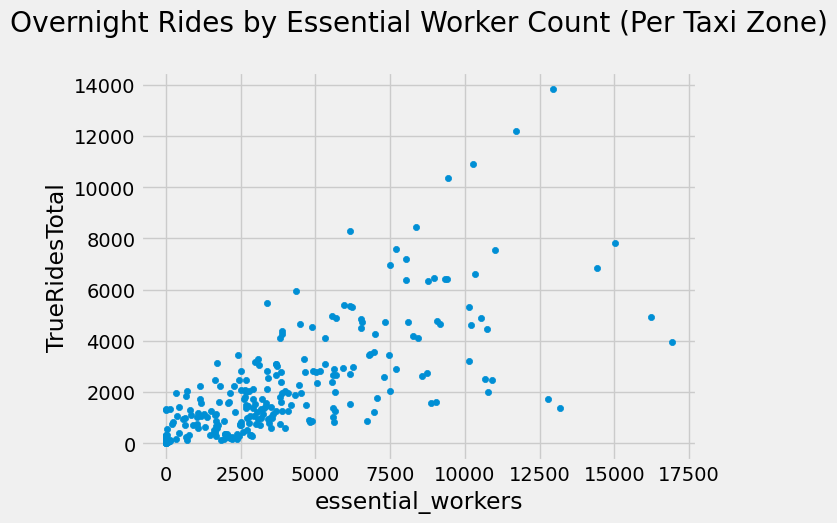

In [347]:
truerides_count.merge(acs[['LocationID','essential_workers']], left_on='index', right_on='LocationID',how='inner')\
.plot.scatter('essential_workers','TrueRidesTotal')
plt.title('Overnight Rides by Essential Worker Count (Per Taxi Zone)\n')

<AxesSubplot:xlabel='essential_workers', ylabel='Total Rides'>

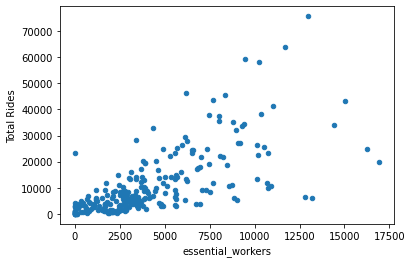

In [497]:
predrides_count.merge(acs[['LocationID','essential_workers']], left_on='index', right_on='LocationID',how='inner')\
.plot.scatter('essential_workers','Total Rides')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


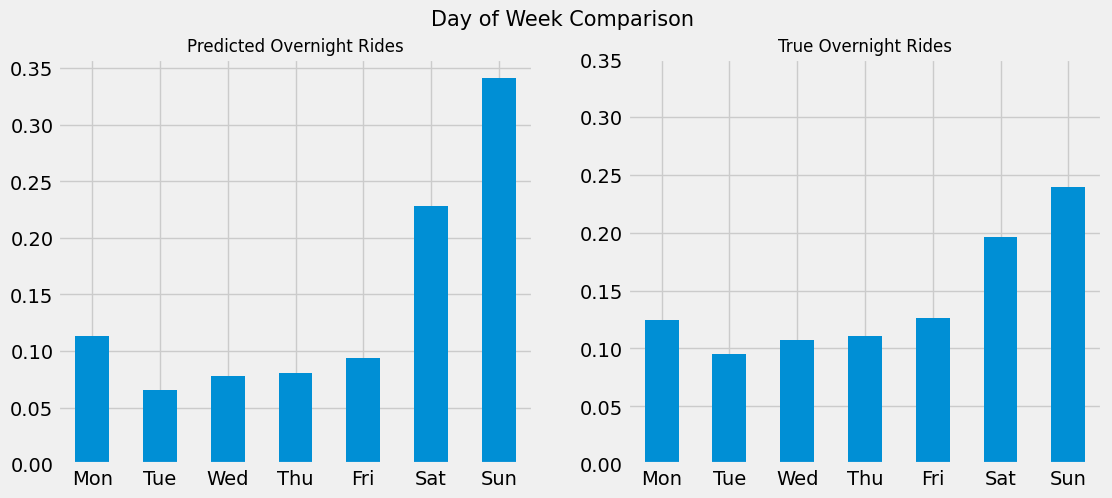

In [458]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,2, figsize=(12,5))
plt.suptitle('Day of Week Comparison\n', fontsize=15)
plt.xticks(rotation=0)


(pred_overnight.iloc[:,5:12].sum() / pred_overnight.iloc[:,5:12].sum().sum()).plot.bar(ax=ax[0])
ax[0].set_title('Predicted Overnight Rides', fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), Rotation=0)

(true_overnight.iloc[:,6:13].sum() / true_overnight.iloc[:,6:13].sum().sum()).plot.bar(ax=ax[1])
ax[1].set_title('True Overnight Rides', fontsize=12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), Rotation=0)

plt.ylim(0,0.35)
plt.xticks(rotation=0)
plt.show()

In [332]:
test_set[test_set['overnight'] == 1]['PCA_x'].mean().compute()

[########################################] | 100% Completed | 20.3s


1.3975630535680692

In [333]:
test_set[test_set['overnight'] == 0]['PCA_x'].mean().compute()

[########################################] | 100% Completed | 19.5s


1.1349147310000456

# Probability Analysis

## Top 100 Most Probable Overight Rides

In [365]:
## 100 Rides with highest probability of being labeled "Overnight"

Top100Probability = FinalPred.compute().sort_values('Probability', ascending=False)[:100]

[########################################] | 100% Completed | 18.5s


In [366]:
Top100Probability.iloc[:,5:12].sum() ## Vast majority of rides are Sunday morning (sat overnight) rides

Mon     0.0
Tue     0.0
Wed     0.0
Thu     0.0
Fri     1.0
Sat    10.0
Sun    89.0
dtype: float64

In [322]:
# 256 and 173 are most common amoung PU Locations with highest probability

Top100Probability['PULocationID'].value_counts()[:10] 

256    17
173    14
35      9
244     8
225     7
61      7
112     7
17      5
148     4
76      4
Name: PULocationID, dtype: int64

In [323]:
# 61, 129, 89 and 255 are most common amoung PU Locations with highest probability

Top100Probability['DOLocationID'].value_counts()[:10]

61     19
129    17
89     14
235    10
49      9
35      8
71      5
37      4
198     4
76      2
Name: DOLocationID, dtype: int64

## PCA comparison

In [ ]:
## ACS PCA value - Pickup and Dropoff ACS PCA value is higher among the model's most probable overnight rides

In [328]:
Top100Probability['PCA_x'].mean(), Top100Probability['PCA_y'].mean()

(2.2592484338185783, 4.2704806064726695)

In [329]:
pred_overnight['PCA_x'].mean(), pred_overnight['PCA_y'].mean()

(1.5783437242658955, 1.6254059762921842)

In [373]:
true_overnight['PCA_x'].mean(), true_overnight['PCA_y'].mean()

(1.3975630535682348, 1.4023720979129177)

## PU and DO Zone Cluster Comparison

In [362]:
pred_overnight.iloc[:,19:-2].sum()

PU_cluster__0.0    109544.0
PU_cluster__1.0    362680.0
PU_cluster__2.0    319941.0
PU_cluster__3.0    220293.0
PU_cluster__4.0     27799.0
DO_cluster__0.0    344475.0
DO_cluster__1.0    134313.0
DO_cluster__2.0    176806.0
DO_cluster__3.0    328766.0
DO_cluster__4.0     55897.0
dtype: float64

In [364]:
true_overnight.iloc[:,20:].sum()

PU_cluster__0.0     35197.0
PU_cluster__1.0     93378.0
PU_cluster__2.0     94308.0
PU_cluster__3.0     53618.0
PU_cluster__4.0      8233.0
DO_cluster__0.0    102530.0
DO_cluster__1.0     41836.0
DO_cluster__2.0     42870.0
DO_cluster__3.0     84356.0
DO_cluster__4.0     13142.0
dtype: float64

In [280]:
## Average Overnight Probability By PU Location

FinalPred.groupby('PULocationID')['Probability'].mean().compute().sort_values()

[########################################] | 100% Completed | 18.9s


PULocationID
161    0.228936
237    0.240571
140    0.250374
13     0.260903
234    0.264152
         ...   
78     0.478065
30     0.478296
10     0.479830
126    0.494223
207    0.532203
Name: Probability, Length: 254, dtype: float64

In [355]:
## Average Overnight Probability By DO Location

FinalPred.groupby('DOLocationID')['Probability'].mean().compute().sort_values()

[########################################] | 100% Completed | 17.6s


DOLocationID
237    0.228029
234    0.240600
163    0.244625
211    0.254988
158    0.256726
         ...   
69     0.477658
235    0.480548
168    0.492229
207    0.547876
126    0.548961
Name: Probability, Length: 254, dtype: float64

In [145]:
# Data from rides in the 95th percentile of probability according to the model

pctle95 = np.percentile(FinalPred['Probability'], 95)
Final_pred_95 = FinalPred[FinalPred['Probability'] > pctle95].compute()

[########################################] | 100% Completed | 19.2s
[########################################] | 100% Completed | 17.4s


In [234]:
# Most Common Pickup Location in 95th Probability Percentile

Final_pred_95['PULocationID'].value_counts()[:10]

61     7350
37     6898
42     5717
76     5034
225    4588
35     4278
39     3968
74     3284
244    3263
177    3233
Name: PULocationID, dtype: int64

In [283]:
# Most Common Dropoff Location in 95th Probability Percentile

Final_pred_95['DOLocationID'].value_counts()[:10]

138    10320
132    10220
61      7279
76      7217
37      4729
35      4373
225     4024
42      3857
168     3775
89      3757
Name: DOLocationID, dtype: int64

In [232]:
# Most frequent Trips in 95th Percentile

Final_pred_95[['PULocationID','DOLocationID']].value_counts()[:10]

PULocationID  DOLocationID
35            76              838
61            76              731
76            35              663
39            76              652
61            35              588
37            37              546
76            61              540
225           61              537
72            76              528
216           132             507
dtype: int64

## Duration

Text(0, 0.5, 'Model Probability')

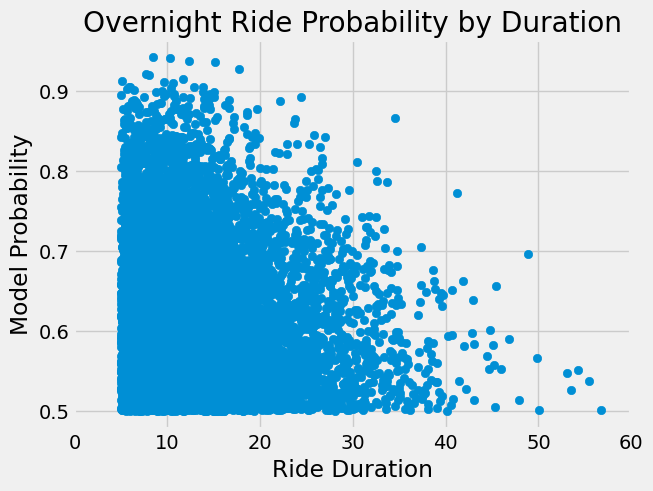

In [439]:
plt.scatter(pred_overnight['Duration'].sample(n=10000, random_state=1), pred_overnight['Probability'].sample(n=10000, random_state=1))
plt.title('Overnight Ride Probability by Duration')
plt.xlabel('Ride Duration')
plt.xlim(0,60)
plt.ylabel('Model Probability')


In [372]:
total_duration = FinalPred['Duration'].mean().compute()
pred_duration = FinalPred[FinalPred['Label'] == 1]['Duration'].mean().compute()

print('\nAverage Ride Duration of Total Test Sample:', total_duration)
print('\n')
print('Average Duration of Predicted Overnight Rides:', pred_duration)
print('\n')
print('Average Ride Duration in 95th-percentile:', Final_pred_95['Duration'].mean())

[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 17.4s

Average Ride Duration of Total Test Sample: 16.436818258588133


Average Duration of Predicted Overnight Rides: 13.427990150510883


Average Ride Duration in 95th-percentile: 13.02670880932611
